# Critical Topic Modeling

The episodes are about four to four and a half hours long. That is a lot of time to spend watching something, so I wanted to know how well an LDA model can describe what happened and if it can tell me the order of which the topics happen. I am coming for you Flando Maltrizian!

## Import Libraries

In [34]:
!pip install pyLDAvis==3.3.1

In [35]:
!pip install ipywidgets

In [36]:
!pip install pandarallel==1.4.8

In [37]:
!python -m spacy download en_core_web_md

     |████████████████████████████████| 96.4 MB 1.0 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


In [38]:
import re
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import spacy
spacy.util.fix_random_seed(0)

import pyLDAvis
import pyLDAvis.gensim_models 

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

from pandarallel import pandarallel

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

## Loading in data, cleaning, tokenizing


### Load

In [39]:
text = open('/content/CR3-16.txt', 'r',encoding = "ISO-8859-1").read()

### Clean

I am probably going to have two cleaning functions. One is going to clean the entire episode. The second will as best as possible only pull lines of the characters and Matt.

First: Clean the entire episode and create a dataframe of lines

In [40]:
def cr_episode_cleaner(episode):
    """
    Clean the data of the entire episode and create a dataframe of the spoken
    lines in the episode. 

    This includes intro, break, outro, character dialog, etc.
    
    Parameters
    ----------
    episode: A large string containing everything spoken during the episode

    Returns
    -------
    lines: A dataframe where every entry is a line spoken during the episode
    """

    return lines

Second: Clean the data of the parts of the episode where there is only character and DM's dialog.

In [41]:
def cr_dialog_cleaner(episode):
    """
    Clean the data of the entire episode and create a dataframe of the spoken
    lines in the episode. 

    This includes intro, break, outro, character dialog, etc.
    
    Parameters
    ----------
    episode: A large string containing everything spoken during the episode

    Returns
    -------
    lines: A dataframe where every entry is dialog spoken during the episode
    """

    # How to locate where the dialog starts and stops
    ending_intro = "And welcome back."
    starting_break = "And we'll pick up from there after our break."
    starting_outro = "We'll pick up on that next week."
    parts = episode.split(ending_intro)
    first_part = parts[1].split(starting_break)[0]
    second_part = parts[-1].split(starting_outro)[0]
    print(first_part[:200])
    print(second_part[:200])
    full_dialog= first_part + "/n" + second_part

    # regex
    remove = string.punctuation
    remove = remove.replace("#", "") # don't remove hyphens
    removing_punctuation = r"[{}]".format(remove)
    non_alpha = '[^a-zA-Z#]'
    spaces = '[^\S ]+'
    multi_white_spaces = "[ ]{2,}"

    full_dialog = re.sub(removing_punctuation, "", full_dialog)
    full_dialog = re.sub(non_alpha, " ", full_dialog)
    full_dialog = re.sub(spaces, '', full_dialog)
    full_dialog = re.sub(multi_white_spaces, " ", full_dialog)
    return pd.DataFrame(full_dialog.lower().split(" # "),columns=['lines'])

In [42]:
full_dialog_df = cr_dialog_cleaner(text)

  
So, last we left off, Hells Bells.  
Bells Hells, I should say.  
# SAM
Yes, you should.  
# MATT
The other way around.  
Brain, thank you.  
# LIAM
First was exclamation, then you said their name.
  
So.  
As Bells Hells are currently jaunting into the darkness, retracing their steps through the aspects of this abandoned mine that they had originally come through, the arcane dome orb that curre


In [43]:
full_dialog_df.head()

,lines
0,so last we left off hells bells bells hells i...
1,sam yes you should
2,matt the other way around brain thank you
3,liam first was exclamation then you said their...
4,matt indeed i was just excited and then presen...


### Tokenizing data for LDA

In [44]:
# identify how many processors your machine has - save the result to `n_processors`
import multiprocessing

n_processors = multiprocessing.cpu_count()
# subtract 1 from n_processors - save the result to `nb_workers`
nb_workers = n_processors - 1
# we must initalize pandarallel before we can use it
pandarallel.initialize(progress_bar=True, nb_workers=nb_workers)
# so that the progress bars will work
from pandarallel.utils import progress_bars
progress_bars.is_notebook_lab = lambda : True

INFO: Pandarallel will run on 3 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [45]:
nlp = spacy.load('en_core_web_md')

In [46]:
# create our tokens in the form of lemmas 
full_dialog_df['lemmas'] = full_dialog_df['lines'].parallel_apply(lambda x: [token.lemma_ for token in nlp(x) if (token.is_stop != True) and (token.is_punct != True)])

In [47]:
# Create lemma dictionary using Dictionary - save result to `id2word`
id2word = corpora.Dictionary(full_dialog_df['lemmas'])

# Create Term Document Frequency list - save result to `corpus`
# Term Document Frequency -- different format, but equivalent in function to the document-term matrix we used in sklearn
corpus = [id2word.doc2bow(doc_lemmas) for doc_lemmas in full_dialog_df['lemmas']]

## LDA Topic Modeling


### Baseline

In [57]:
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=10, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

In [58]:
from gensim.models import CoherenceModel
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=full_dialog_df['lemmas'], dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.3511298952498839


### Attempt 1

In [49]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                                        id2word=id2word,
                                                        num_topics=num_topics, 
                                                        chunksize=100,
                                                        passes=10,
                                                        random_state=1234,
                                                        per_word_topics=True,
                                                        workers=2)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [50]:
%%time 
start=2; limit=14;  step=2;
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=full_dialog_df['lemmas'], start=start, limit=limit, step=step)

CPU times: user 37.3 s, sys: 6.21 s, total: 43.6 s
Wall time: 42.5 s


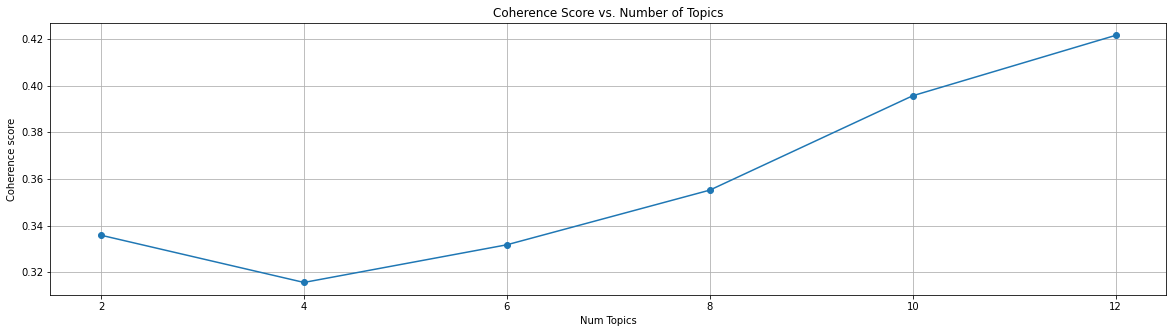

In [51]:
x = range(start, limit, step)

plt.figure(figsize=(20,5))
plt.grid()
plt.title("Coherence Score vs. Number of Topics")
plt.xticks(x)
plt.plot(x, coherence_values, "-o")

plt.xlabel("Num Topics")
plt.ylabel("Coherence score")

plt.show();

In [52]:
# use np.argmax() to get index of largest coherence value from coherence_values - save result to `max_cohereance_val_index`
max_coherence_val_index = np.argmax(coherence_values)
# use `max_coherence_val_index` to index model_list for the corresponding model - save result to `lda_trained_model`
lda_trained_model = model_list[max_coherence_val_index]

In [71]:
coherence_model_lda = CoherenceModel(model=lda_trained_model, texts=full_dialog_df['lemmas'], dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.4214842769724935


In [53]:
lda_trained_model.print_topics()

[(0,
  '0.269*"sam" + 0.044*"point" + 0.033*"damage" + 0.033*"matt" + 0.031*"need" + 0.026*"take" + 0.022*"throw" + 0.020*"day" + 0.017*"saving" + 0.016*"familiar"'),
 (1,
  '0.190*"okay" + 0.131*"matt" + 0.093*"right" + 0.033*"ashley" + 0.031*"check" + 0.031*"pretty" + 0.029*"mean" + 0.025*"fearne" + 0.020*"hard" + 0.017*"plus"'),
 (2,
  '0.289*"marisha" + 0.158*"oh" + 0.045*"travis" + 0.031*"shit" + 0.031*"sleep" + 0.027*"fucking" + 0.026*"god" + 0.026*"fuck" + 0.013*"nightmare" + 0.013*"pop"'),
 (3,
  '0.244*"taliesin" + 0.055*"little" + 0.027*"yep" + 0.025*"right" + 0.022*"leave" + 0.021*"night" + 0.019*"bit" + 0.019*"like" + 0.018*"drink" + 0.015*"hurt"'),
 (4,
  '0.203*"laura" + 0.120*"not" + 0.117*"ashley" + 0.054*"think" + 0.053*"want" + 0.041*"yes" + 0.037*"laughter" + 0.022*"great" + 0.016*"fine" + 0.011*"work"'),
 (5,
  '0.192*"go" + 0.142*"be" + 0.047*"try" + 0.022*"laura" + 0.018*"run" + 0.016*"use" + 0.013*"time" + 0.013*"sleep" + 0.012*"gold" + 0.011*"cover"'),
 (6,
  '0

In [54]:
# plot your topics here -- using pyLDAvis
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_trained_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9      0.118080  0.053501       1        1  13.030539
7     -0.132583  0.159140       2        1   8.720629
10    -0.070877 -0.167220       3        1   8.640044
5     -0.134674 -0.134993       4        1   8.593580
1      0.090027  0.155431       5        1   8.187440
8     -0.006186  0.106125       6        1   8.181559
4     -0.299318  0.101019       7        1   8.101604
0      0.081404  0.042835       8        1   7.993156
6      0.206057  0.126573       9        1   7.968473
11     0.022852 -0.079415      10        1   7.751233
2      0.121840 -0.210002      11        1   6.703457
3      0.003379 -0.152993      12        1   6.128285, topic_info=         Term        Freq       Total Category  logprob  loglift
4         sam  427.000000  427.000000  Default  30.0000  30.0000
269   marisha  384.000000  384.000000  Default  29.0000  29.0000
431      yeah  359.000000  359.000000  Default  28.0000  28.0000
277     laura  494.000000  494.000000  Default  27.0000  27.0000
446  taliesin  296.000000  296.000000  Default  26.0000  26.0000
..        ...         ...         ...      ...      ...      ...
29        bit   23.346856   67.246885  Topic12  -3.9509   1.7343
43      close   10.329373   27.243026  Topic12  -4.7664   1.8224
380     right   30.688044  224.069637  Topic12  -3.6775   0.8042
136      like   23.009293  182.306388  Topic12  -3.9655   0.7225
205      room    8.477729   53.441246  Topic12  -4.9639   0.9511

[518 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
505       2  0.842618   ability
835       2  0.824035      able
2499      2  0.755764  absolute
582      11  0.830733   academy
969       4  0.680876    action
...     ...       ...       ...
753      11  0.940720       wow
1838      3  0.927965     wrong
431       2  0.996424      yeah
482      12  0.960910       yep
5         7  0.982948       yes

[551 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 8, 11, 6, 2, 9, 5, 1, 7, 12, 3, 4])

### Attempt 2 
I am not a big fan of 1 and 10 overlapping as much as they do, so did some research into tuning the model better than how it is currently.

In [55]:
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b,
                                           workers=2)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=full_dialog_df['lemmas'], dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [ ]:
import tqdm
grid = {}
grid['Validation_Set'] = {}

# Topics range
min_topics=2
max_topics=11
step_size=1
topics_range=range(min_topics, max_topics, step_size)

# Alpha parameter
alpha = list(np.arange(0.01,1,0.3))
alpha.append('symmetric')
alpha.append('asymmetric')

# Beta parameter
beta = list(np.arange(0.01,1,0.3))
beta.append('symmetric')

# Validation sets
num_of_docs = len(corpus)
corpus_sets = [# gensim.utils.ClippedCorpus(corpus, num_of_docs*0.25), 
               # gensim.utils.ClippedCorpus(corpus, num_of_docs*0.5), 
               gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.75)), 
               corpus]

corpus_title = ['75% Corpus', '100% Corpus']
model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

if 1 == 1:
    pbar = tqdm.tqdm(total=500)
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=id2word, k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    pbar.update(1)
    pd.DataFrame(model_results).to_csv('lda_tuning_results.csv', index=False)
    pbar.close()

In [75]:
lda_model_2 = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=0.90999,
                                           eta=0.01)

In [76]:
coherence_model_lda = CoherenceModel(model=lda_model_2, texts=full_dialog_df['lemmas'], dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.4851026686164584


In [77]:
lda_model_2.print_topics()

[(0,
  '0.336*"ashley" + 0.309*"okay" + 0.045*"say" + 0.039*"laugh" + 0.037*"great" + 0.029*"fine" + 0.021*"strength" + 0.020*"hey" + 0.011*"course" + 0.010*"sam"'),
 (1,
  '0.279*"marisha" + 0.204*"sam" + 0.156*"oh" + 0.062*"roll" + 0.028*"need" + 0.025*"god" + 0.017*"attack" + 0.017*"wait" + 0.016*"day" + 0.014*"ahead"'),
 (2,
  '0.211*"travis" + 0.203*"s" + 0.128*"right" + 0.063*"laughter" + 0.059*"good" + 0.039*"come" + 0.033*"let" + 0.029*"mean" + 0.028*"pretty" + 0.026*"fucking"'),
 (3,
  '0.145*"like" + 0.072*"point" + 0.068*"feel" + 0.066*"hit" + 0.055*"damage" + 0.050*"thing" + 0.050*"matt" + 0.038*"laudna" + 0.033*"gus" + 0.025*"sorry"'),
 (4,
  '0.589*"matt" + 0.056*"yes" + 0.041*"way" + 0.037*"check" + 0.027*"thank" + 0.025*"orym" + 0.022*"taliesin" + 0.021*"miss" + 0.021*"nightmare" + 0.016*"bad"'),
 (5,
  '0.357*"laura" + 0.248*"yeah" + 0.076*"get" + 0.047*"ill" + 0.035*"time" + 0.025*"sam" + 0.018*"have" + 0.018*"lot" + 0.016*"d" + 0.011*"seven"'),
 (6,
  '0.242*"go" + 0

In [78]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model_2, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8     -0.099992  0.279395       1        1  12.989819
7     -0.196390  0.207351       2        1  12.890760
2      0.018541  0.039902       3        1  10.048874
3     -0.230898 -0.107061       4        1   9.887515
6      0.140357  0.013619       5        1   9.821122
9      0.040785 -0.246545       6        1   9.555002
4     -0.229394 -0.196825       7        1   9.075247
1      0.222858 -0.020464       8        1   9.042960
5      0.207181  0.085561       9        1   8.922527
0      0.126952 -0.054932      10        1   7.766174, topic_info=         Term         Freq        Total Category  logprob  loglift
7        matt  1238.000000  1238.000000  Default  30.0000  30.0000
277     laura   631.000000   631.000000  Default  29.0000  29.0000
280    ashley   517.000000   517.000000  Default  28.0000  28.0000
406      okay   475.000000   475.000000  Default  27.0000  27.0000
269   marisha   499.000000   499.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
1058     burn    11.812642    12.408207  Topic10  -4.8691   2.5062
4         sam    15.460283   452.366379  Topic10  -4.6000  -0.8208
380     right     7.266097   280.732665  Topic10  -5.3550  -1.0988
327         s     3.288290   422.456773  Topic10  -6.1479  -2.3003
7        matt     2.945850  1238.372158  Topic10  -6.2578  -3.4858

[387 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
505       3  1.012699   ability
835       5  1.040030      able
582       8  0.968208   academy
969       5  0.997844    action
565       5  0.998455  actually
...     ...       ...       ...
621       9  1.099349      year
808       7  0.906072      yell
675      10  0.861859      yelp
482       6  1.006902       yep
5         7  0.996809       yes

[410 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 8, 3, 4, 7, 10, 5, 2, 6, 1])

### Visualing topics better!

In [81]:
def format_topics_sentences(ldamodel, corpus=corpus, texts=full_dialog_df['lemmas']):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,10), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model_2, corpus=corpus, texts=full_dialog_df['lemmas'])

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

In [82]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.374811,"ashley, okay, say, laugh, great, fine, strength, hey, course, sam","[ashley, okay, okay, okay]"
1,1.0,0.448186,"marisha, sam, oh, roll, need, god, attack, wait, day, ahead","[matt, attack, roll, roll, add, proficiency, bonus, strength, modifier, dexterity, modifier, whi..."
2,2.0,0.413002,"travis, s, right, laughter, good, come, let, mean, pretty, fucking","[travis, s, shine, s, reminiscent, yeah, right, s, leather, strap]"
3,3.0,0.516726,"like, point, feel, hit, damage, thing, matt, laudna, gus, sorry","[matt, olly, point, keep, partially, invisible, keep, invisible, point, come, help, distance, fi..."
4,4.0,0.373615,"matt, yes, way, check, thank, orym, taliesin, miss, nightmare, bad","[matt, way, brain, thank]"
5,5.0,0.401093,"laura, yeah, get, ill, time, sam, have, lot, d, seven","[taliesin, yeah, okay, yeah, right, get, stick, maybe, be, go, try, different, d, time, like, nu..."
6,6.0,0.525441,"go, be, try, shit, fuck, maybe, ball, foot, actually, use","[taliesin, be, go, push, be, go, try, run, foot, cover]"
7,7.0,0.761051,"little, stone, bit, look, shade, turn, hear, fearne, light, matt","[matt, light, go, ahead, throw, singular, red, bead, arc, past, rasp, look, shoulder, shooting, ..."
8,8.0,0.828207,"have, rest, pull, mind, throw, people, help, saving, sit, see","[matt, excited, presentory, bell, hells, barely, escape, chaos, ball, center, core, spire, jrusa..."
9,9.0,0.672956,"not, taliesin, liam, know, think, want, yep, take, will, sure","[marisha, yep, yep, yep, yep, yep, yep, yep, yep, yep, yep, yep, yep, yep, yep, yep, yep, uhhuh,..."


# Final Thoughts
I would say that there needs to be a lot more cleaning... Topic 0 and 9 are a great example. I also want to encorperate bigram and trigrams into the model.

Good first go!